In [1]:
import logging
import os
import sys
from typing import Union

import pandas as pd
import numpy as np
import tensorflow as tf
import yaml
from dlomix.models import PrositIntensityPredictor
from numpy.typing import NDArray

import shap
import matplotlib.pyplot as plt
import matplotlib
matplotlib.use('inline')
sys.path.append(os.getcwd())

from src.models.model_wrappers import ModelWrapper, model_wrappers
from src.shap_prosit.shap_calculator import ShapCalculator

tf.get_logger().setLevel(logging.ERROR)



with open("config.yaml", encoding="utf-8") as file:
    config = yaml.safe_load(file)["shap_calculator"]

#if not os.path.exists(config["ion"]):
#   os.makedirs(config["ion"])

# Shuffle validation dataset and split it in background and validation.
val_data = np.array([m.split(",") for m in open(config["val_inps_path"]).read().split("\n")])
if config["perm_path"] is None:
    perm = np.random.permutation(np.arange(len(val_data)))
    np.savetxt(output_path + "/perm.txt", perm, fmt="%d")
else:
    perm = np.loadtxt(config["perm_path"]).astype(int)
bgd_sz = config['bgd_sz']
bgd = val_data[perm[:bgd_sz]]
val = val_data[perm[bgd_sz:]]

2024-09-30 18:35:29.055216: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-30 18:35:29.055267: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-30 18:35:29.056995: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-30 18:35:31.409453: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT



Avaliable feature extractors are (use the key of the following dict and pass it to features_to_extract in the Dataset Class):
{
   "atom_count": "Atom count of PTM.",
   "delta_mass": "Delta mass of PTM.",
   "mod_gain": "Gain of atoms due to PTM.",
   "mod_loss": "Loss of atoms due to PTM.",
   "red_smiles": "Reduced SMILES representation of PTM."
}.
When writing your own feature extractor, you can either
    (1) use the FeatureExtractor class or
    (2) write a function that can be mapped to the Hugging Face dataset.
In both cases, you can access the parsed sequence information from the dataset using the following keys, which all provide python lists:
    - _parsed_sequence: parsed sequence
    - _n_term_mods: N-terminal modifications
    - _c_term_mods: C-terminal modifications



In [19]:
def local_explanation(
    sequence, 
    charge, 
    energy,
    ion='y5+1',
    samp=100
):
    space = (30-len(sequence))*[""]
    calc_input = np.array(list(sequence) + space + [str(energy), str(charge)], dtype='<U4')[None]

    sc = ShapCalculator(ion, val, bgd, model_wrapper=model_wrapper)
    bgd_pred = model_wrapper.make_prediction(bgd)
    bgd_mean = np.mean(bgd_pred)
    
    out_dict = sc.calc_shap_values(calc_input, samp=samp)
    ext = int(ion[1])
    poslambda = lambda a: a-1-(len(sequence)-ext) if ion[0]=='y' else ext-a-1
    tokens = ['%s_%d'%(b, poslambda(a)) for a,b in enumerate(sequence)]
    explanation = shap.Explanation(out_dict['shap_values'], base_values=bgd_mean, feature_names=tokens)
    
    plt.close()
    matplotlib.use('inline')
    shap.waterfall_plot(explanation)

Prosit_2019_intensity::   0%|          | 0/1 [00:00<?, ?it/s]

Prosit_2019_intensity::   0%|          | 0/1 [00:00<?, ?it/s]

Prosit_2019_intensity::   0%|          | 0/1 [00:00<?, ?it/s]

Prosit_2019_intensity::   0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Prosit_2019_intensity::   0%|          | 0/1 [00:00<?, ?it/s]

Prosit_2019_intensity::   0%|          | 0/1 [00:00<?, ?it/s]

Prosit_2019_intensity::   0%|          | 0/1 [00:00<?, ?it/s]

Prosit_2019_intensity::   0%|          | 0/1 [00:00<?, ?it/s]

Prosit_2019_intensity::   0%|          | 0/1 [00:00<?, ?it/s]

Prosit_2019_intensity::   0%|          | 0/1 [00:00<?, ?it/s]

Prosit_2019_intensity::   0%|          | 0/1 [00:00<?, ?it/s]

Prosit_2019_intensity::   0%|          | 0/1 [00:00<?, ?it/s]

Prosit_2019_intensity::   0%|          | 0/1 [00:00<?, ?it/s]

Prosit_2019_intensity::   0%|          | 0/1 [00:00<?, ?it/s]

Prosit_2019_intensity::   0%|          | 0/1 [00:00<?, ?it/s]

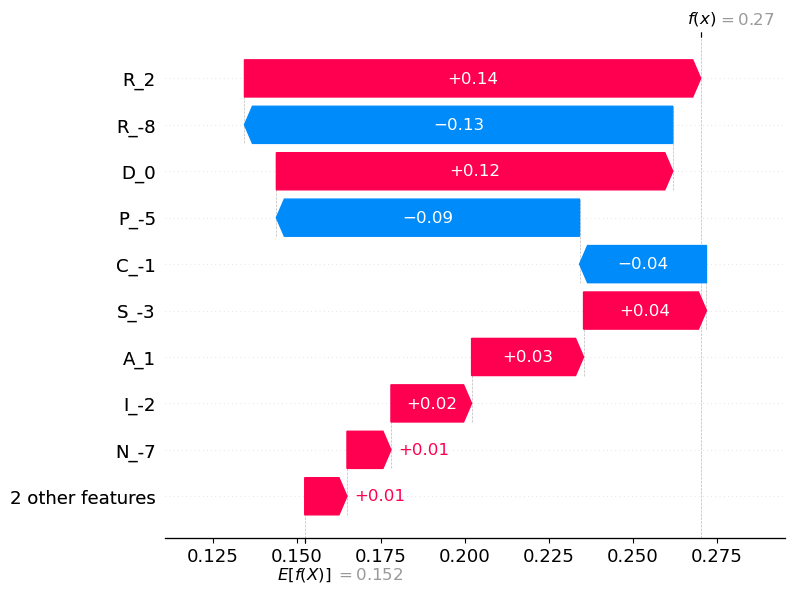

In [25]:
ion='b3+1'
model_wrapper = model_wrappers[config["model_type"]](
    path=config["model_path"], ion=ion
)
local_explanation("RADCISEPVNR", 3, 0.3, ion=ion, samp=100)